In [ ]:
# Analyze the distribution of chemical potentials during the probe pulse,
# i.e. when the THG is calculated, for several Fermi energies.
# The reason is that the Gamma function is evaluated at the average
# chemical potential in time, so it is useful to know which values the chemical
# potentials sample (as a function of the fixed Fermi energy) to understand
# how the profile of Gamma should look, in order to have a smaller or larger THG.

In [1]:
import time
import math
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import simps
from scipy.optimize import minimize
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import json
from datetime import datetime
import multiprocessing as mp
import glob

In [2]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

In [3]:
from models.graphene_optics import GrapheneTHG

In [21]:
# Load the data of the time-evolution.

runDir = "./data/04/2023-08-19-08-26-12_gamma_fit"
eF_list = np.loadtxt("%s/eF_list.csv" % runDir, delimiter=", ")
pr_delay_list = np.loadtxt("%s/delay_list.csv" % runDir, delimiter=", ")
# Values with pump and probe.
thg_eF_delay = []
for i_eF in range(len(eF_list)):
    thg_delay = []
    for i_delay in range(len(pr_delay_list)):
        with open("%s/thg_data-%02d-%02d.json" % (runDir, i_eF, i_delay), "r") as f:
            thg_delay.append(json.load(f))
    thg_eF_delay.append(thg_delay)
# Values without pump.
thg0_eF = []
for i_eF in range(len(eF_list)):
    with open("%s/thg_data-%02d.json" % (runDir, i_eF), "r") as f:
        thg0_eF.append(json.load(f))
    

In [37]:
# Meaning of the last index.
ii = {
    "muC_avg": 0,
    "muV_avg": 1,
    "mueff_avg": 2,
    "mueff_std": 3,
    "tempK_avg": 4
}

stats_eF_delay = []
for thg_eF in thg_eF_delay:  # all Fermi energies
    stats_delay = []
    for thg_data in thg_eF:  # all delays
        vals = []
        for args in thg_data["args"]:  # all time steps in the probe pulse
            vals.append([ args["muC"], args["muV"], 0.5*(np.abs(args["muC"])+np.abs(args["muV"])), args["tempK"] ])
        vals = np.array(vals)
        stats_delay.append([
            vals[:,0].mean(),
            vals[:,1].mean(),
            vals[:,2].mean(),
            vals[:,2].std(),
            vals[:,3].mean()
        ])
    stats_eF_delay.append(stats_delay)
stats_eF_delay = np.array(stats_eF_delay)
    
stats0_eF = []
for thg_data in thg0_eF:  # all Fermi energies
    vals = []
    for args in thg_data["args"]:  # all time steps in the probe pulse
        vals.append([ args["muC"], args["muV"], 0.5*(np.abs(args["muC"])+np.abs(args["muV"])), args["tempK"] ])
    vals = np.array(vals)
    stats0_eF.append([
        vals[:,0].mean(),
        vals[:,1].mean(),
        vals[:,2].mean(),
        vals[:,2].std(),
        vals[:,3].mean()
    ])
stats0_eF = np.array(stats0_eF)



In [69]:
saveDir = "./data/07/mu_vs_efermi"

In [82]:
stats0_eF[:,ii["mueff_std"]].shape

(31,)

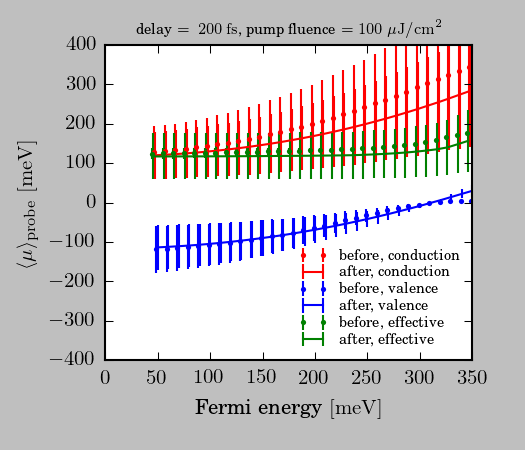

In [92]:
# Choose one time index.
t0 = 200.0
it0 = np.abs(pr_delay_list - t0).argmin()

mpl.style.use(["classic", "latex"])
plt.figure(figsize=(3.5,3.0), frameon=True, dpi=150)
plt.axes([0.2, 0.2, 0.7, 0.7])
# horizontal displacement to avoid errorbars overlapping
plt.errorbar(eF_list * 1.0e+3 - 3, 1.0e+3 * stats0_eF[:,ii["muC_avg"]],
             yerr=0.5 * 1.0e+3 * stats0_eF[:,ii["muC_avg"]], fmt=".r", ms=5.0, mew=0.0, label="before, conduction")
plt.errorbar(eF_list * 1.0e+3 - 2, 1.0e+3 * stats_eF_delay[:,it0,ii["muC_avg"]],
             yerr=0.5 * 1.0e+3 * stats_eF_delay[:,it0,ii["muC_avg"]], fmt="-r", ms=3.0, mew=0.0, label="after, conduction")
plt.errorbar(eF_list * 1.0e+3 - 1, 1.0e+3 * stats0_eF[:,ii["muV_avg"]],
             yerr=0.5 * 1.0e+3 * stats0_eF[:,ii["muV_avg"]], fmt=".b", ms=5.0, mew=0.0, label="before, valence")
plt.errorbar(eF_list * 1.0e+3 - 0, 1.0e+3 * stats_eF_delay[:,it0,ii["muV_avg"]],
             yerr=0.5 * 1.0e+3 * stats_eF_delay[:,it0,ii["muV_avg"]], fmt="-b", ms=3.0, mew=0.0, label="after, valence")
plt.errorbar(eF_list * 1.0e+3 - 5, 1.0e+3 * stats0_eF[:,ii["mueff_avg"]],
             yerr=0.5 * 1.0e+3 * stats0_eF[:,ii["mueff_std"]], fmt=".g", ms=5.0, mew=0.0, label=r"before, effective")
plt.errorbar(eF_list * 1.0e+3 - 4, 1.0e+3 * stats_eF_delay[:,it0,ii["mueff_avg"]],
             yerr=0.5 * 1.0e+3 * stats_eF_delay[:,it0,ii["mueff_avg"]], fmt="-g", ms=3.0, mew=0.0, label="after, effective")
plt.xlim([0.0, 350.0])
plt.ylim([-400.0, 400.0])
plt.xlabel(r"Fermi energy $[{\rm meV}]$")
# plt.ylabel(r"$\eta_{\rm THG}$")
plt.title(r"\scriptsize $\mbox{delay} = ~%.0f\,{\rm fs}$, $\mbox{pump fluence} = 100~\mu{\rm J}/{\rm cm}^{2}$" % pr_delay_list[it0])
plt.legend(frameon=False, loc="lower right", fontsize="x-small", labelspacing=0.2)
plt.ylabel(r"$\langle \mu \rangle_{\rm probe}~[{\rm meV}]$")
plt.savefig(r"%s/muavg_vs_efermi-280-100.png" % saveDir, dpi=300)
